<h1>Computer Programming project - Federico Giorgi (3197626)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy 
import time

In [2]:
def accept_with_prob(delta_cost, beta):
    if delta_cost <= 0:
        return True

    if beta == np.inf:
        return False
    
    prob = np.exp(-beta*delta_cost)
    
    return np.random.random() < prob 

In [3]:
def generate_data(n, seed):
    if type(seed) != str:
        raise TypeError("The seed should be the string representing your ID")
    if type(n) != int:
        raise TypeError("The dimension of the problem should be an integer value")
    if n%2 != 0:
        raise ValueError("The dimension of the problem should be even!!")
    
    aggregate_counter = 0
    for char in seed:
        aggregate_counter += int(char)
    
    aggregate_counter = 10*aggregate_counter
    marginal_diff = int(aggregate_counter)%n 
    bsize = 12 + int(np.floor(n**(1/2)))
    if (bsize%2)!=0:
        bsize=bsize-1
    
    if (marginal_diff<bsize+4):
        marginal_diff = bsize+4  
    if (marginal_diff > (n-bsize-4)):
        marginal_diff = n-bsize-4
    if ((marginal_diff > n/2 - bsize-5) and (marginal_diff < n/2+bsize+5)):
        marginal_diff = int(n/2-bsize-5)
    
    c_marginal_diff = n-marginal_diff
    
    b1 = -100 + np.random.randn(bsize, bsize)
    b2 = -50 + np.random.randn(bsize, bsize)
    

    f_values = np.zeros((n,n), dtype=np.float32)
    f_values = 1+ 0.05*np.random.randn(n,n)
    f_values[marginal_diff-bsize//2:marginal_diff+bsize//2, c_marginal_diff-bsize//2:c_marginal_diff+bsize//2] = b1
    f_values[c_marginal_diff-bsize//2:c_marginal_diff+bsize//2, marginal_diff-bsize//2:marginal_diff+bsize//2] = b2
    return f_values

data = generate_data(100, "3197626")

## Task 1
Implement a class for the problem (like the one done in class for the TSP problem) following the above instructions and the suggestions given in the general information area. Then use the class of simulated annealing used during the classes.

Here there is the implemented class

In [4]:
class OPT():
    def __init__(self, data):
        self.data = data
        self.n = data.shape[0]
        self.x = -1
        self.y = -1


    def init_config(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        n = self.n

        self.x = np.random.choice(np.arange(n))
        self.y = np.random.choice(np.arange(n))


    def display(self):
        plt.clf()
        matrix = np.transpose(self.data) 
        # It is trasposed in order to have the row index is on the x-axis and the column index on the y-axis
        plt.imshow(matrix)
        plt.colorbar(label='Value')
        plt.xlabel('Row Index')
        plt.ylabel('Column Index')
        plt.plot(self.x, self.y, marker="o", color="red")
        plt.show()
        plt.pause(0.01)

   
    def propose_move(self):
        i, j, n = self.x, self.y,  self.data.shape[0]
        x_proposed = np.random.choice([(i - 1) % n, (i + 1) % n])
        y_proposed = np.random.choice([(j - 1) % n, (j + 1) % n])
        move = (x_proposed, y_proposed)
        return move
    

    def accept_move(self, move):
        x_proposed, y_proposed = move
        self.x = x_proposed
        self.y = y_proposed


    def cost(self):
        return self.data[self.x, self.y]


    def compute_delta_cost(self, move):
        x_proposed, y_proposed = move
        current_cost = self.cost()
        proposed_cost = self.data[x_proposed, y_proposed]
        return proposed_cost - current_cost


    def copy(self):
        return deepcopy(self)

Here there is the simulated annealing used during the classes

In [5]:
def simann(probl, beta0=0.1, beta1=10., anneal_steps=10, mcmc_steps=10, seed=None):
    
    if seed is not None:
        np.random.seed(seed)
    
    probl.init_config()
    cx = probl.cost()
    print(f"Initial cost is c = {cx}")
    
    best_c = cx
    best_probl = probl.copy()
    
    betas = np.zeros(anneal_steps)
    betas[:-1] = np.linspace(beta0, beta1, anneal_steps-1)
    betas[-1] = np.inf
    
    for beta in betas:
        accepted_moves = 0
        for t in range(mcmc_steps):
            move = probl.propose_move()
            delta_c = probl.compute_delta_cost(move)

            if accept_with_prob(delta_c, beta):
                accepted_moves += 1
                probl.accept_move(move)
                cx += delta_c
                #probl.display()

                if best_c >= cx: 
                    best_c = cx
                    best_probl = probl.copy()
                    #best_probl.display()
        
        # print(f"beta= {beta}, accept_freq= {accepted_moves/mcmc_steps}, c={cx}, best_c={best_c}")
    
    # best_probl.display()
    best_c = best_probl.cost()
    print(f"Best Cost = {best_c}")

    return best_probl, best_c

Here it is possible to test it, it takes roughly 0,4 seconds.

In [15]:
probl = OPT(data)
simann(probl, anneal_steps=100, mcmc_steps = 200, seed = None)

Initial cost is c = 0.9564800244869655
Best Cost = -102.16613598666424


(<__main__.OPT at 0x25e7fdd2340>, -102.16613598666424)

# Task 2
The modulo operation defined above does seem a little too complex for its use (basically taking care of the borders), can you explain why it might be convenient both from a mathematical
and implementation point of view to allow such border jumping? If I don’t allow it, what part of the code should I change and why?

### Mathematical point of view
The simulated annealing procedure uses the montecarlo chains to reproduce a probability distribution and must have a symmetric proposal scheme, i.e. the chance that x' gets proposed given x must be the same as the chance that x gets proposed given x'. If the border jumping is not allowed, the symmetry property of the proposal move doesn't work anymore.  
Moreover, it is also not possible to consider the borders as exception cases: the probability to get to a border node from a non-border point is 0.25, while the probability to go back to the point x will be 0.5.

### Implementation point of view
If the border jumping is not allowed and the modulo operation is not used, a point on the edge that proposes a move that is out of the matrix will give an index error.

### How to modify the code?
If we do not allow border jumping and are still consistent with the simulated annealing process, we could add a layer of elements on the edges with infinite cost. In this way, the probability that a point of the "new frontier" will be accepted is equal to 0 but the proposal procedure will still be symmetrical for the "explorable states". It will therefore not be necessary to modify the propose move scheme nor to change the problem; however we still need to modify the initial class matrix and enforce that the starting point is not a boundary point.

# Task 3
Study the performance of the algorithm as the temperature changes for a fixed value of 𝑛, does the annealing procedure help in finding the minima? (RK: the minima should be around −100 for any 𝑛)

"simann_task3" is a modified versione of Simulated Annealing alghorithm: it stores the best cost found in each temperature (1/beta) and returns the betas and the best costs. In this way, we can understand the performance of the algorithm as the temperature changes for a given n.

"average_results_task3" is used to do more iterations and obtain the average best cost at each temperature.

In [7]:
def simann_task3(probl, beta0=0.1, beta1=10., anneal_steps=10, mcmc_steps=10, seed=None):
    if seed is not None:
        np.random.seed(seed)

    probl.init_config()
    cx = probl.cost()
    #print(f"Initial cost is c = {cx}")
    
    best_c = cx
    best_probl = probl.copy()
    
    betas = np.zeros(anneal_steps)
    betas[:-1] = np.linspace(beta0, beta1, anneal_steps-1)
    betas[-1] = np.inf
    costs = []

    for beta in betas:
        accepted_moves = 0
        for t in range(mcmc_steps):
            move = probl.propose_move()
            delta_c = probl.compute_delta_cost(move)

            if accept_with_prob(delta_c, beta):
                accepted_moves += 1
                probl.accept_move(move)
                cx += delta_c
                #probl.display()

                if best_c >= cx: 
                    best_c = cx
                    best_probl = probl.copy()
                    #best_probl.display()

        costs.append(best_c)

        # print(f"beta= {beta}, accept_freq= {accepted_moves/mcmc_steps}, c={cx}, best_c={best_c}")
    
    # best_probl.display()
    best_c = best_probl.cost()
    # print(f"Best Cost = {best_c}")

    return betas, costs

In [8]:
def average_results_task3(probl, iterations, anneal_steps):
    costs = np.zeros((anneal_steps, iterations))
    for i in range(iterations-1):
        betas, cost = simann_task3(probl, beta0=0.001, beta1=10., anneal_steps=anneal_steps, mcmc_steps=200)
        costs[:,i] = cost
    avg_costs = np.mean(costs, axis=1)
    return betas, avg_costs

In [9]:
def plot_task3(betas, avg_costs, iterations):
    plt.plot(betas, avg_costs, label='Average Cost')
    plt.xlabel("Betas")
    plt.ylabel("Cost")
    plt.title(f"Average Best Cost at Each Temperature of the Annealing Procedure with {iterations} iterations")
    plt.grid(True)
    plt.legend()
    plt.show()

Here it is possible to test it, it takes roughly 1:30 minutes.

In [10]:
betas, avg_costs = average_results_task3(probl, iterations=100, anneal_steps=200)

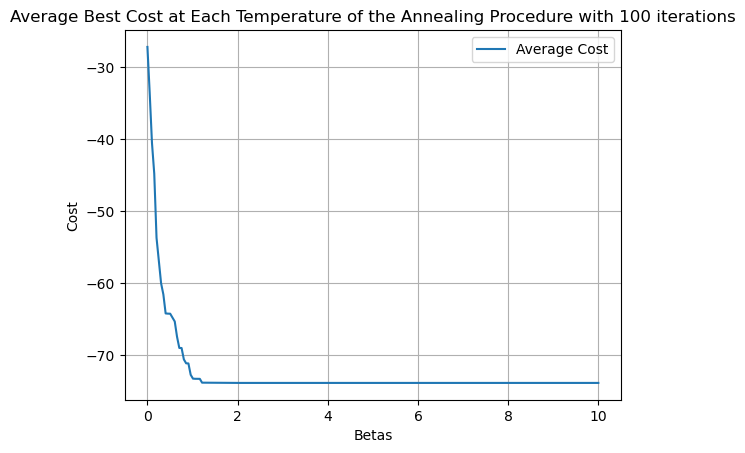

In [11]:
plot_task3(betas, avg_costs, iterations=100)

As the graph suggests, the average best cost decrease drastically in the first 20% of the annealing procedure, and then remains constant. The intuition behind is the following: the exploration finds a position that make the best cost drop very fast, and then the point stays in a region of very similar costs until convergence. This is coherent with what we studied: when beta is small (large T) the acceptance rate is high but we get bad c(x); increasing beta (lower T) the acceptance rate reduces and we have lower c(x) typically.

However, it should be pointed out that the descendent of the cost is not smooth as it seems since it describes the average.

# Task 4
Study the performance of the algorithm under random initialization for some reasonable
increasing dimensions for the problem (like 𝑛 = [100, 200, 500, 1000, 5000]) in terms of convergence speed and eventual convergence success. What can you say about it? NB: Notice that to find the minimum we can just np.min(f).

"simann_task4" is a modified versione of Simulated Annealing alghorithm: it measure the convergence time and the convergence success. The function stops when the acceptance rate is zero, in fact this means that, during all the mcmc steps, all the move proposals were discarded.

"average_results" is used, again, to do more iterations and obtain the average time and the success rate

In [12]:
def simann_task4(probl, beta0=0.1, beta1=10., anneal_steps=10, mcmc_steps=10, seed=None):

    if seed is not None:
        np.random.seed(seed)
    
    t0 = time.time()
    
    probl.init_config() 
    cx = probl.cost()
    #print(f"Initial cost is c = {cx}")
    
    best_c = cx
    best_probl = probl.copy()
    
    betas = np.zeros(anneal_steps)
    betas[:-1] = np.linspace(beta0, beta1, anneal_steps-1)
    betas[-1] = np.inf
    
    for beta in betas:
        accepted_moves = 0
        for t in range(mcmc_steps):
            move = probl.propose_move()
            delta_c = probl.compute_delta_cost(move)

            if accept_with_prob(delta_c, beta):
                accepted_moves += 1
                probl.accept_move(move)
                cx += delta_c
                #probl.display()

                if best_c >= cx: 
                    best_c = cx
                    best_probl = probl.copy()
                    #best_probl.display()

        acceptance_frequency = accepted_moves/mcmc_steps
        # print(f"beta= {beta}, accept_freq= {acceptance_frequency}, c={cx}, best_c={best_c}")

        if acceptance_frequency == 0:
            success = (abs(best_c + 100) < 5)
            t1 = time.time()
            execution_time = t1 - t0
            return execution_time, success

    success = (abs(best_c + 100) < 3)
    t1 = time.time()
    execution_time = t1 - t0
    return execution_time, success


In [13]:
def average_results_task4(probl, iterations):
    times = np.zeros(iterations-1, dtype=float)
    results = np.zeros(iterations-1, dtype=int)
    for i in range(iterations-1):
        execution_time, success = simann_task4(probl, beta0=0.001, beta1=10., anneal_steps=100, mcmc_steps=200)
        times[i] = execution_time
        results[i] = success
    average_time = np.mean(times)
    success_rate = np.mean(results)
    return average_time, success_rate 

The following code generates problems with different dimensions and returns: 
1) the average execution time; 
2) the success rate.  

It takes roughly 4:30 minutes.

In [15]:
ns = [100,200,300,400,500,600,700,800,1000]
l = len(ns)
iterations=100

problems_ns = [OPT(generate_data(n, "3197626")) for n in ns]
average_times = np.zeros(l)
success_rates = np.zeros(l)
for i in range(l):
    average_time, success_rate = average_results_task4(problems_ns[i], iterations)
    average_times[i] = average_time
    success_rates[i] = success_rate

In [17]:
def plot_comparison_graphs_task4(ns, average_times, success_rates):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.plot(ns, average_times, label='Average time')
    ax1.set_xlabel('Size of the matrix')
    ax1.set_ylabel('Time (in s)')
    ax1.legend()
    
    ax2.plot(ns, success_rates, label='Success rate')
    ax2.set_xlabel('Size of the matrix')
    ax2.set_ylabel('Success rate (%)')
    ax2.legend()

    plt.suptitle('Average time and success rate with matrices of different sizes')
    plt.show()

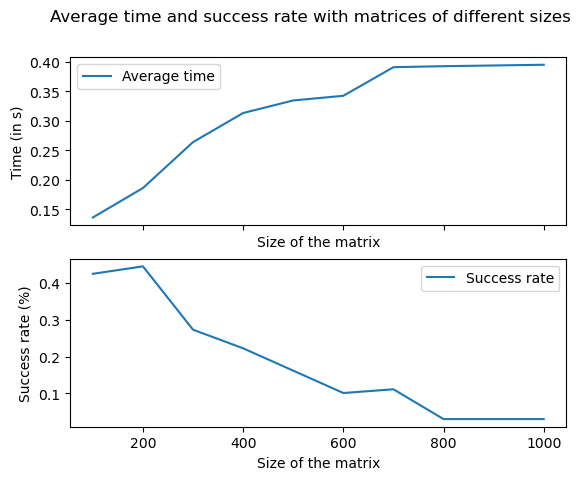

In [18]:
plot_comparison_graphs_task4(ns, average_times, success_rates)

As the two graphs suggest: 
1) the time of convergence increases with the size of the matrix; 
2) the success rate decreases with the size of the matrix.

As a fact, as n increases the algorithm has to explore a wider portion of the matrix. 
However, the fact that, as the matrix is increasing, it is more and more difficult for the algorithm to solve the problem, suggests that the proportion of the points of minima (with respect to the whole matrix) decrease as the size of the matrix increases.

In fact, when n is relatively small, the algorithm explores a good amount of space of the matrix, thus there is an higher probability that it finds a local/optimal minimum and subsequently the success rate is higher.

# Task 5
Record at every step of the algorithm the acceptance probability of the moves, what can you say about them? Can this give you some insight into the landscape you are trying to optimize?

To study the behavior of acceptance probability, we will use the accepted frequency.  They capture the same essence of the annealing scheme but the accepted frequency is easier to store.

"simann_task5" is a modified versione of Simulated Annealing alghorithm: it returns the accepted frequncies, as before explained, the delta costs at each annealing step and the betas, since they are needed to compute the acceptance probability.

In [6]:
def simann_task5(probl, beta0=0.1, beta1=10., anneal_steps=10, mcmc_steps=10, seed=None):
    
    if seed is not None:
        np.random.seed(seed)
    
    probl.init_config()
    cx = probl.cost()
    #print(f"Initial cost is c = {cx}")
    
    best_c = cx
    best_probl = probl.copy()
    
    betas = np.zeros(anneal_steps)
    betas[:-1] = np.linspace(beta0, beta1, anneal_steps-1)
    betas[-1] = np.inf
    
    accepted_frequencies = np.zeros(anneal_steps)
    deltas = np.zeros(anneal_steps)
    
    i = -1
    for beta in betas:
        i += 1
        accepted_moves = 0
        beta_delta = np.zeros(mcmc_steps)
        
        for t in range(mcmc_steps):
            move = probl.propose_move()
            delta_c = probl.compute_delta_cost(move)

            if accept_with_prob(delta_c, beta):
                accepted_moves += 1
                probl.accept_move(move)
                cx += delta_c
                #probl.display()

                beta_delta[t] = delta_c

                if best_c >= cx: 
                    best_c = cx
                    best_probl = probl.copy()
                    #best_probl.display()

        accepted_frequency = accepted_moves/mcmc_steps
        # print(f"beta= {beta}, accept_freq= {accepted_frequency}, c={cx}, best_c={best_c}")

        deltas[i] = np.sum(beta_delta)
        accepted_frequencies[i] = accepted_frequency
    # print(best_c)
    return accepted_frequencies, betas, deltas

In [7]:
def plot_task5(betas, accepted_freq, deltas):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.plot(betas, accepted_freq, label='Accepted frequency', color='blue')
    ax1.set_xlabel('Betas')
    ax1.set_ylabel('Accepted frequency (%)')
    ax1.legend()

    ax2.plot(betas, deltas, label='Delta costs at each annealing step', color='green')
    ax2.set_xlabel('Betas')
    ax2.set_ylabel('Delta cost')
    ax2.legend()

    plt.suptitle('Acceptance probability analysis')
    plt.show()

Since the initialization of the process and the acceptance probability are random, the behavior of the acceptance frequency changes from run to run. In the following analysis, I plotted the accepted frequency and the delta cost for each beta, this allows us to understand some general trends.

When the algorithm succeeds:
1) the accepted frequency drops after a relatively small amount of steps;
2) at the sime time, there is a big increase in the total delta cost of that step.

This means that the point has fallen in a into a region of smaller cost and all the moves exiting the area are being rejected, influencing in this way the acceptance rate. The following two examples confirm our intuition.

### Example 1
In this example, the initial position is far from the minimum. There is a sharp delta cost (-100) only at almost 40% of the annealing procedures, all the moves exiting the area are being rejected and thus the accepted frequency reaches the zero. 

In [12]:
example1 = OPT(data)
simann(example1, beta0=0.1, beta1=10., anneal_steps=100, mcmc_steps = 200, seed=13)

Initial cost is c = 0.9840591882352184
Best Cost = -52.45772091362306


(<__main__.OPT at 0x25e7fdd2670>, -52.45772091362306)

In [18]:
simann(probl, beta0=0.1, beta1=10., anneal_steps=100, mcmc_steps = 200, seed=13)

Initial cost is c = 0.9840591882352184
Best Cost = -52.45772091362306


(<__main__.OPT at 0x25e7fec18b0>, -52.45772091362306)

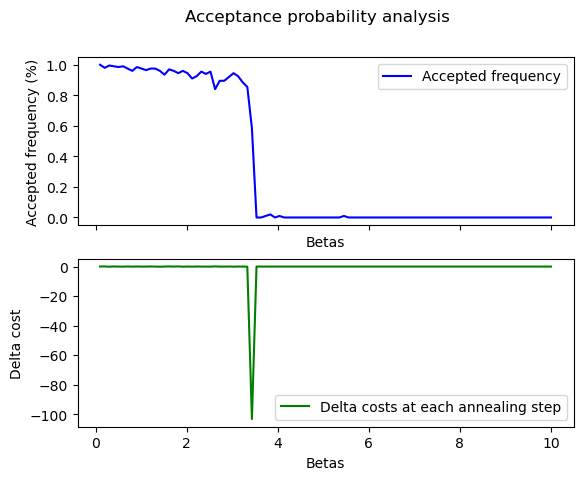

In [ ]:
accepted_freq, betas, deltas = simann_task5(probl, beta0=0.1, beta1=10., anneal_steps=100, mcmc_steps = 200, seed=13)
plot_task5(betas, accepted_freq, deltas)

### Example 2
In this example, the initial position is very close to the minimum. There is a sharp delta cost (-100) at the first annealing step, then the point remains in a region of very similar costs until convergence.

In [20]:
simann(probl, beta0=0.1, beta1=10., anneal_steps=100, mcmc_steps = 200, seed=4)

        

Initial cost is c = 1.0089359090415826
Best Cost = -102.97346950211025


(<__main__.OPT at 0x25e7fec47f0>, -102.97346950211025)

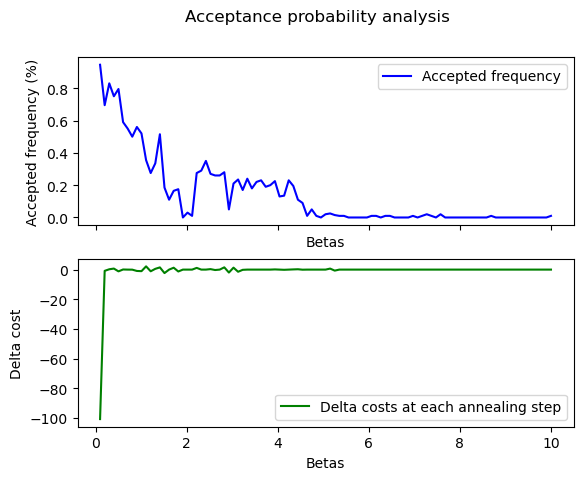

In [ ]:
accepted_freq, betas, deltas = simann_task5(probl, beta0=0.1, beta1=10., anneal_steps=100, mcmc_steps = 200, seed=4)
plot_task5(betas, accepted_freq, deltas)

# Task 6
Plot the optimization for a fixed value of n. What can you say about this landscape? Can you connect it to the behavior you observe in the acceptance probabilities and to the behavior of simulated annealing at different temperatures?

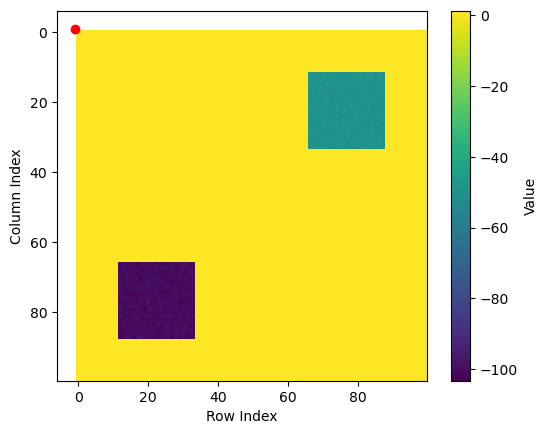

In [30]:
probl6 = OPT(data)
probl6.display()

The output is constant at around zero for a wide range of values. However, there are two areas with smaller values: one around -100 and the other around -50; within these areas the output is almost constant. This landscape was almost anticipated by the conclusions we reached in the previous points.

### Acceptance probability
Through Task 3 and 5, we understood that the function presented sharp decreases in its values and regions of very similar costs. That is coherent with the presented landscape: when the algorithm finds a minimima there is a sharp decrease in the value from around 0 to around -100 or -50, then the point remains within the small square without exiting. Moreover, the average best cost of -80 is in fact the average between -50 and -100.

### Behavior of simulated annealing at different temperatures
When beta is small and the temperature is high the acceptance rate is high, thus the algorithm explores the matrix and accept to move even in points with higher value, when beta is higher and the temperature is lower T the acceptance rate reduces, thus it points toward the area of minima. of the function with good precision. 

# Task 7
After having observed all the above, do you think simulated annealing is an adequate algorithm for the problem considered? Is it better than, for example, a greedy strategy? Think of what could be the best optimisation algorithm for such a problem. Explain in detail your answer by directly referencing results/observations obtained in the previous points.

The greedy algorithm would obtain worst results than the simulated annealing because the exploration would stop at the first local minimum, thus it doesn't allow a broad exploration. On the contrary, simulated annealing becomes more greedy as the annealing steps go on.

## Simulated Annealing with random guessing proposal move
Simulated annealing is a decent algorithm when solving the problem for small sizes: in Task 4 we saw it has a success rate of around 60\%. 
However, it isn't effective as n increases and we cannot solve this problem changing the simulated annealing procedure and keeping the proposed step equal to 1; because when n increases the space to explore becomes larger and thus we would need to increase also the number of annealing and mcmc steps to explore a wider area. However, this would increase the the execution time.

In the following section I implemented a subclass, OPT2, with a different propose move: the choice of the indexes is totally random within the matrix excluding the current coordinates.  In this way, the algorithm can explore a wider area of the matrix, going from  point to another and keeping track of the best cost.
However note that this change is only effective when we considered a landscape with a limited number of regions with similar costs.

In [ ]:
class OPT2(OPT):
    def propose_move(self):
        i = self.x 
        j = self.y 
        n = self.data.shape[0]
        while True:
            x_prop = np.random.choice(np.arange(n))
            y_prop = np.random.choice(np.arange(n))
            if x_prop != i or y_prop != j:
                break
        return x_prop, y_prop

In [ ]:
def plot_comparison_graphs_task7(ns, average_times, success_rates, 
                           average_times_2, success_rates_2):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.plot(ns, average_times, label='Average time OPT')
    ax1.plot(ns, average_times_2, label='Average time OPT2')
    ax1.set_xlabel('Size of the matrix')
    ax1.set_ylabel('Time (in s)')
    ax1.legend()
    
    ax2.plot(ns, success_rates, label='Success rate OPT')
    ax2.plot(ns, success_rates_2, label='Success rate OPT2')
    ax2.set_xlabel('Size of the matrix')
    ax2.set_ylabel('Success rate (%)')
    ax2.legend()

    plt.suptitle('Average time and success rate with matrices of different sizes')
    plt.show()

In [ ]:
ns = [100,200,300,400,500,600,700,800,1000]
l = len(ns)
iterations=100

problems_ns_2 = [OPT2(generate_data(n, "3197626")) for n in ns]
average_times_2 = np.zeros(l)
success_rates_2 = np.zeros(l)
for i in range(l):
    average_time_2, success_rate_2 = average_results_task4(problems_ns_2[i], iterations)
    average_times_2[i] = average_time_2
    success_rates_2[i] = success_rate_2

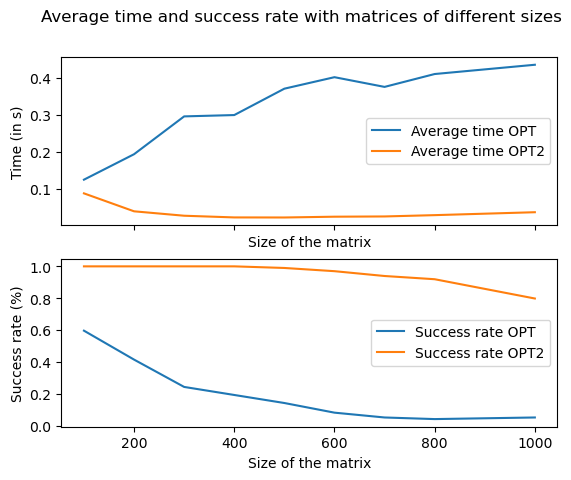

In [ ]:
plot_comparison_graphs_task7(ns, average_times, success_rates, average_times_2, success_rates_2)

As the graphs suggest, OPT2 is more efficient and less time consuming. It should be noticed that random guessing is more effective than OPT when the size of the matrix increases; while for small matrices random guessing is slightly more effective than exploring the matrix.